# Processing quadtree output
There are several modeling codes out there, and they all use a different input format. Here is an example of reformatting the output of the <i>kite</i> quadtree decomposition we just used for use in one such code, <i>okinv</i>.

Import some things:

In [1]:
import numpy as np
from kite import Scene
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import math
import utm
from osgeo import gdal

Set some file names:

In [2]:
inyml="elazig_asc_kite_scene"
#incsv="ridgecrest_dsc_quadtree.csv"
outbase="elazig_asc"

And load in the quadtree'd data:

In [3]:
sc=Scene.load(inyml)
qt=sc.quadtree

The reference point in <i>kite</i> is the lower left (SW) corner of the interferogram. (Note that <i>ISCE</i>, and indeed most geospatial imaging formats, use the upper left corner.)

In [4]:
reflat=sc.frame.llLat
reflon=sc.frame.llLon

# we would also like the reference point in utm coordinates
refutm=utm.from_latlon(reflat,reflon)

print("reference point (lat-long):",reflat,"N",reflon,"E")

print("reference point (utm):",refutm[0],"E",refutm[1],"N")

reference point (lat-long): 37.845 N 38.21222222222222 E
reference point (utm): 430689.34856238903 E 4188910.023342772 N


Extracting the various information from the kite output is fairly straightforward. 'leaf_focal_points' is the name given to the centers of each quadtree cell, and is provided both in meters in a local coordinate system, as well as in long-lat. 

The definitions of incidence ('qt.leaf_thetas') and azimuth ('qt.leaf_phis') in <i>kite</i> are a little unusual (as seems to be common in InSAR, everyone has their own convention!) Here, the convention is up-looking, towards the satellite, with the azimuth being counter-clockwise from the East. Both values are in radians. 

We can convert this fairly easily to other definitions such as 'range change', i.e. with the unit line-of-sight (LOS) vector pointing from the satellite to the ground target, by doing some simple trigonometry. (It is probably a good idea to draw the problem, to see how this works...)

In [5]:
# xy positions of data points in utm kilometers
#xkm=(refutm[0]+qt.leaf_focal_points_meter[:,0])/1000
#ykm=(refutm[1]+qt.leaf_focal_points_meter[:,1])/1000

# xy positions of data points in long-lat
xyll=np.column_stack((qt.leaf_focal_points[:,0]+reflon,qt.leaf_focal_points[:,1]+reflat))

# los vector components using kite definiton of coordinates
losx=np.cos(qt.leaf_thetas)*-np.cos(qt.leaf_phis)
losy=np.cos(qt.leaf_thetas)*-np.sin(qt.leaf_phis)
losz=-np.sin(qt.leaf_thetas)

# id for each datapoint
dataptid=np.arange(1,losx.size+1)

In [6]:
# let's convert our lat-long coordinates to UTM km
xym = utm.from_latlon(xyll[:,1],xyll[:,0]) 
xkm = xym[0]/1000
ykm = xym[1]/1000

We can plot the points, just to make sure that our conversion makes sense.

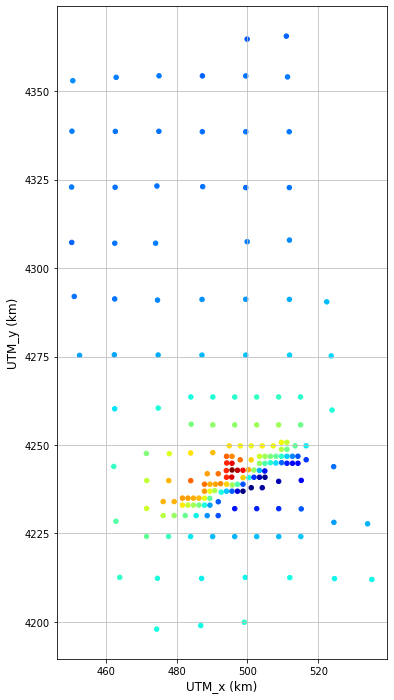

In [7]:
fig = plt.figure(figsize=(6,12))

ax = fig.add_subplot(111)
ax.set_xlabel("UTM_x (km)",fontsize=12)
ax.set_ylabel("UTM_y (km)",fontsize=12)
ax.grid(True,linestyle='-',color='0.75')

# scatter with colormap mapping to z value
ax.scatter(xkm,ykm,s=20,c=qt.leaf_means, marker = 'o', cmap = cm.jet );
ax.set_aspect('equal')

plt.show()

Finish by outputting the data to file, in one example format. The following format, based on the okinv code, has seven columns:

x_coordinate(km) y_coordinate(km) los_displacement(m) unit_los_x unit_los_y unit_los_z id

In [8]:
# okinv format in km
okinv_data=np.column_stack((xkm,ykm,qt.leaf_means,losx,losy,losz,dataptid))
outfile=outbase+".okinv"
np.savetxt(outfile,okinv_data,fmt='%f %f %f %f %f %f %d')

# okinv format in lat-long 
okinv_data_ll=np.column_stack((xyll,qt.leaf_means,losx,losy,losz,dataptid))
outfile=outbase+"_ll"+".okinv"
np.savetxt(outfile,okinv_data_ll,fmt='%f %f %f %f %f %f %d')